Link to Github:
https://github.com/BrugerX/CompSocSciAssgnmt1

Contributions:
The two other members of my group have decided to unenroll in the course.

The code for the first two excercises was not done by me, while the third was done by me.
All answers were written by me.
Me being Benjamin Mirad Gurini, s214590.

In [21]:
from bs4 import BeautifulSoup ##A package to work with HTML data
import requests #A package to make HTTP requests
import pandas as pd
import re

## Web scraping of 2019 - PART 1 EXCERCISE 1


#### Posters

In [22]:
LINK_2019 = "https://2019.ic2s2.org/posters/"
r_2019 = requests.get(LINK_2019)
soup_19 = BeautifulSoup(r_2019.content)

In [3]:
for strong_tag in soup_19.find_all('strong'):
    strong_tag.decompose()
all_rows_19 = soup_19.find_all("li")

In [4]:
rows_19_posters = []
for i in range(32,len(all_rows_19)-8):
    text = all_rows_19[i].text
    sep = "\xa0"
    author = text.split(sep, 1)[0]
    author = re.sub(r'(?<![^\W\d_])AND(?![^\W\d_])', ',', author, flags=re.IGNORECASE)
    author = author.split(",")
    for i in author:
        rows_19_posters.append(i)

In [5]:
df_19_posters = pd.DataFrame(rows_19_posters, columns=['authors'])
df_19_posters = df_19_posters[df_19_posters['authors'].str.strip().astype(bool)]
df_19_posters = df_19_posters.drop_duplicates()

In [6]:
df_19_posters.shape

(481, 1)

#### Oral presentations

In [7]:
LINK_2019_oral = "https://2019.ic2s2.org/oral-presentations/"
r_2019_oral = requests.get(LINK_2019_oral)
soup_19_oral = BeautifulSoup(r_2019_oral.content)

In [8]:
all_presentations_lst = soup_19_oral.find("div","main").findChild("div").findChild("div").findChild("article").findChild("div").findChild("div","col-md-8").findAll("p")[3:]

In [9]:
#Retruns a string where TIME0 - TIME1 - has been removed
def getTextAfterTimestamp(text):
    incrementer = 0
    idx_end_of_timeStamp = 0
    for idx,c in enumerate(text):
        if (c == "–"):
            incrementer += 1
            if (incrementer == 2):
                idx_end_of_timeStamp = idx + 1

    return text[idx_end_of_timeStamp::]

#Returns a set of names from a string formatted as: NAME0,NAME1,...,NAMEn{.,-}
def getNamesFromText(text):
    text = text[1:]
    endingChars = {".":True,"–":True}
    result_set = set()
    current_name_string = ""

    for idx,c in enumerate(text):
        if(endingChars.get(c,False) and not text[idx-1].isupper()): #We check to see if the char is an ending char, and the letter before it wasn't an initial
            result_set.add(current_name_string)
            return result_set
        elif (c == ","):
            result_set.add(current_name_string)
            current_name_string = ""
        else:
            if(c.isalpha() or len(current_name_string)>0): #We don't want spacebar at the start of the names
                current_name_string += c

    return result_set

def getNameFromChair(text):
    text = text.split(":")
    name = text[1]
    nameFiltered = ""

    for chr in name:
        if(chr.isalpha() or len(nameFiltered)>0):
            nameFiltered+= chr

    return nameFiltered

In [10]:
set_of_names = set()
for presentations in all_presentations_lst:
    chairAndName = presentations.find("em").string
    set_of_names.add(getNameFromChair(chairAndName))

In [11]:
for presentations in all_presentations_lst:
    text = str(presentations)
    presentations_list = text.split("<")
    for presentation in presentations_list:
        if (len(presentation)>0 and presentation[0] == "b"): #We now have the start of each break
            presentation_text = getTextAfterTimestamp(presentation)
            if(not "No presentation" in presentation_text):
                set_of_names = set_of_names.union(getNamesFromText(presentation_text))

# Manual corrections
set_of_names.remove("r/>The Higher Education Space")
set_of_names.remove("Moved to 3D Text Analysis) Ivan Smirnov")
set_of_names.add("Ivan Smirnov")

In [12]:
df_19_orals = pd.DataFrame(set_of_names, columns=['authors'])
df_19_orals = df_19_orals.drop_duplicates()

#### Combine 2019

In [13]:
df_19 = pd.concat([df_19_orals, df_19_posters])
df_19 = df_19.drop_duplicates()

In [17]:
unique_Authors = df_19.shape[0]
print(unique_Authors)

1007


In [15]:
#df_19.to_csv('df_19_authors.csv')  - we don't actually want to save it after the first time

#### Part 1 - Excercise 2: Number of unique authors

The number of unique authors is saved in the "unique_Authors" variable, and it is 1007 authors.

#### Part 1 - Excercise 3: Which decisions did you make? Why? And how might it have impacted the number of unique authors?

So the final webscraping algorithm wasn't done by me. I did the one labelled "Benjamin - week1_excercises" I couldn't load some of the years with my Python, so we opted out for letting Jasmin (a previous participant of the course and member of the group) do the web scrapings.

I do not know, what she chose. But I decided in my example to remove the space after the final "-" in the time of the presentation and the first character of each name from the 2019 oral presentations. Not doing this might've resulted in the same names being recognized as two different names, as " Benjamin Mirad Gurini" wouldn't be the same as "Benjamin Mirad Gurini."

Example:
12:15 – 12:30 – Gustavo Jota Resende

Would end up as "Gustavo Jota Resende" and not " Gustavo Jota Resende".


#### Part 2 - Excercise 1: Number of unique authors, which years we used and collaborators

We will use 126549 authors.

We chose all years and collaborators were included.

In [29]:
df_all_authors = pd.read_csv("authorids_and_collaborators.csv", dtype={'authorId':str})
print(f"Number of unique authors: {df_all_authors.shape[0]}")

Number of unique authors: 126549


In [ ]:
#We now get all the data into a singe list
BASE_URL = "https://api.semanticscholar.org/graph/"
VERSION = "v1/"
RESOURCE = "author/batch"

params = "fields=aliases,name,papers.title,papers.abstract,papers.year,papers.externalIds,papers.s2FieldsOfStudy,papers.citationCount,papers.authors"

my_url = BASE_URL + VERSION + RESOURCE

author_ids = {'ids':list(df_all_authors.authorId.values)}
author_ids_lst = author_ids['ids']

all_data = []

for itr in range(0, len(df_all_authors), 60):
    print(itr)
    items = author_ids_lst[itr:itr+60]

    json_author_ids = {'ids':list(items)}

    r = requests.post(my_url, json = json_author_ids, params = params)
    print(r)
    data = r.json()

    all_data.append(data)

    #If we don't sleep we'll overload the APi and get error 500's
    time.sleep(5)

In [ ]:
all_data_list = [item for sublist in all_data for item in sublist]

In [ ]:
import json
with open('data.json', 'w') as file:
    json.dump(all_data_list, file)

In [ ]:
# Author dataset
author_dataset_dict = {"author_id": [], "name": [], "aliases": [], "field": [], "citationCount": [] }

for item, itr in zip(all_data_list, range(len(all_data_list))):

    print(itr)
    if item == 'message' or item==None:
        pass
    else:
        author_id = item['authorId']
        name = item['name']


        try:
            aliases = item['aliases']
        except TypeError:
            continue


        category = []

        if len(all_data_list[itr]['papers']) == 0:
               pass
        else:
            for i in range(len(all_data_list[itr]['papers'])):
                s2FieldsOfStudy = item['papers'][i]['s2FieldsOfStudy']
                cat = [d['category'] for d in s2FieldsOfStudy]
                category.append(cat)

            category = [lst for lst in category if lst]

            flat_cat = [item for sublist in category for item in sublist]

            if flat_cat:
                counts = Counter(flat_cat)
                most_common_category = counts.most_common(1)[0][0]

        sum_citationCount = 0

        if len(all_data_list[itr]['papers'])==0:
               pass
        else:
            for i in range(len(all_data_list[itr]['papers'])):
                citationCount = item['papers'][i]['citationCount']
                sum_citationCount = citationCount + sum_citationCount


        author_dataset_dict['author_id'].append(author_id)
        author_dataset_dict['name'].append(name)
        author_dataset_dict['aliases'].append(aliases)
        author_dataset_dict['field'].append(most_common_category)
        author_dataset_dict['citationCount'].append(sum_citationCount)

In [ ]:
author_dataset_df = pd.DataFrame(author_dataset_dict)
author_dataset_df = author_dataset_df.drop_duplicates(subset=['author_id'])

In [ ]:
author_dataset_df.to_csv('author_dataset.csv')

### Paper dataset

In [ ]:
paper_dataset_dict = {"paper_id": [], "title": [], "year": [], "externalIds": [], "citationCount": [],
                      "fields": [],"author_ids": []}

for item, itr in zip(all_data_list, range(len(all_data_list))):
    print(itr)

    if item == 'message' or item==None:
        pass
    else:
        papers_data = [(p['authors'],p['paperId'], p['title'], p['year'], [d['category']
                for d in p['s2FieldsOfStudy']], p['citationCount'], p['externalIds']) for p in all_data_list[itr]['papers']]


        for authors, paper_id, tit, years, categories, citation_count, externalIds in papers_data:

            if externalIds.get('DOI'):
                doi = externalIds['DOI']
            else:
                doi = ''

            authorIds_list_coll = [d['authorId'] for d in authors]

            paper_dataset_dict['paper_id'].append(paper_id)
            paper_dataset_dict['title'].append(tit)
            paper_dataset_dict['year'].append(years)
            paper_dataset_dict['externalIds'].append(doi)
            paper_dataset_dict['citationCount'].append(citation_count)
            paper_dataset_dict['fields'].append(categories)
            paper_dataset_dict['author_ids'].append(authorIds_list_coll)

In [ ]:
paper_dataset_df = pd.DataFrame(paper_dataset_dict)

In [ ]:
paper_dataset_df = paper_dataset_df.drop_duplicates('paper_id')

In [ ]:
paper_dataset_df.to_csv('paper_dataset.csv')

### Paper abstract dataset

In [ ]:
        for i in range(len(all_data_list[itr]['papers'])):
            paper_id = item['papers'][i]['paperId']
            abstract = item['papers'][i]['abstract']

            paper_abstract_dataset_dict['paper_id'].append(paper_id)
            paper_abstract_dataset_dict['abstract'].append(abstract)

In [ ]:
# Paper abstract dataset

paper_abstract_dataset_dict = {"paper_id": [], "abstract": []}

for item, itr in zip(all_data_list, range(len(all_data_list))):

    if item == 'message' or item==None:
        pass
    else:
        paper_ids = [p['paperId'] for p in all_data_list[itr]['papers']]
        abstracts = [p['abstract'] for p in all_data_list[itr]['papers']]

        for paperid in paper_ids:
            paper_abstract_dataset_dict['paper_id'].append(paperid)

        for abstract in abstracts:
            paper_abstract_dataset_dict['abstract'].append(abstract)

In [ ]:
paper_abstract_dataset_df = pd.DataFrame(paper_abstract_dataset_dict)

In [ ]:
paper_abstract_dataset_df = paper_abstract_dataset_df.drop_duplicates(subset=['paper_id'])

In [ ]:
paper_abstract_dataset_df.to_csv("paper_abstract_dataset_df.csv")

In [21]:
#So we don't have to run the whole code again:
paper_dataFrame = pd.read_csv(r"paper_dataset.csv")
author_dataFrame = pd.read_csv(r"author_dataset.csv")

print(f"Length of the paper data set: {len(paper_dataFrame)} \nLength of the author data set: {len(author_dataFrame)}")

Length of the paper data set: 4505707 
 Length of the author data set: 94465


#### Part 2 - Excercis 3: Length of the two datasets

As can be seen from running the previous code block we have that:

The length of the paper dataset is 4505707 and the length of the author dataset is 94465.

So on average, we have approximately 45 papers per author.

#### Part 3 - The Code

### Part 3 - Excercise 1

We start by creating some functions for calculating cummulative statistics we will use throughout the excercise.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

In [2]:
def cummulativeAverage(array):
    Cum_avg = []
    for x in range(1,len(array) + 1):
        Cum_avg += [np.sum(array[0:x])/x]

    return Cum_avg

def cummulativeMean(array):
    Cum_mean = []
    for x in range(1,len(array) + 1):
        Cum_mean += [np.mean(array[0:x])]

    return Cum_mean

def cummulativeMed(array):
    Cum_med = []
    for x in range(1,len(array) + 1):
        Cum_med += [np.median(array[0:x])]

    return Cum_med

def cummulativeSTD(array):
    Cum_STD = []
    for x in range(1,len(array) + 1):
        Cum_STD += [np.std(array[0:x])/math.sqrt(x)]

    return Cum_STD

#Creates the X-vector
def createXVector(n):
    XVector = []
    for x in range(n):
        XVector += [x]

    return XVector


#returns a dict, which we can easily use to plot all the graphs - we could've used a DF, but no need to bother with that, we just need to plot the arrays
def getCummulativeStatistics(YVector):
    dict = {"cumAvg":cummulativeAverage(YVector),"cumMed":cummulativeMed(YVector),"cumSTD":cummulativeSTD(YVector)}
    return dict

In [3]:
#Heavy tailed histograms need to be plotted on logarithmic scale, otherwise it will just be single big horizontal bar
def getFixAxHeavyTailedHistogram(data,bins=500):
    fig,ax = plt.subplots()
    ax.hist(data,bins=np.logspace(0,np.log10(max(data)),bins),density=True) #500 appears to give us the most information without zooming too far out
    ax.set_yscale("log")
    ax.set_xscale("log")
    return fig,ax


#Function for plotting all the different statistics
def getStatisticsPlot(cumStatsDic,distStatsDic,XVector):
    Cum_avg = cumStatsDic["cumAvg"]
    Cum_STD = cumStatsDic["cumSTD"]
    Cum_med = cumStatsDic["cumMed"]
    Dist_med = distStatsDic["distMed"]
    Dist_mean = distStatsDic["distMean"]

    fig,ax = plt.subplots(2,1)
    ax[0].errorbar(XVector,Cum_avg,yerr=Cum_STD,c="orange",ecolor="cyan",label="Cummulative mean")
    ax[0].axhline(Dist_mean,c="green",label="Distribution mean")
    ax[1].axhline(Dist_med,c="orange",label="Distribution median")
    ax[1].plot(XVector,Cum_med,c="blue",label="Cummulative median")
    ax[1].set_xlabel("Sample size")
    ax[0].set_ylabel("Cummulative average")
    ax[1].set_ylabel("Cummulative median")
    #fig.legend(loc="center right") - the legend couldn't fit anywhere
    return fig,ax


In [ ]:
### Gaussian distribution

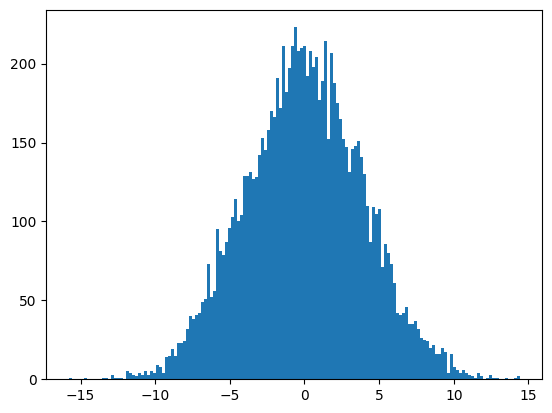

In [4]:
n = 10000
sigma = 4
Y_Norm = sigma * np.random.standard_normal(n)
plt.hist(Y_Norm,bins=150)

#We get the statistics
XVector = createXVector(n)

cummulative_Stats_Norm = getCummulativeStatistics(Y_Norm)

#Based on the formulas from Wikipedia (https://en.wikipedia.org/wiki/Normal_distribution):

norm_mean = 0
norm_median = 0
norm_dist_dict = {"distMed":norm_median,"distMean":norm_mean}

### This will be the same for all the plots:

Upper plot:
The cyan blue vertical bars are cummulative standard errors at the given sample size
The orange line is the cummulative mean/average at the given sample size
The horizontal light green line is the theoretical distribution average/mean

Lower plot:
The dark blue line is the cummulative median at the given sample size
The flat orange line is the theoretical distribution median

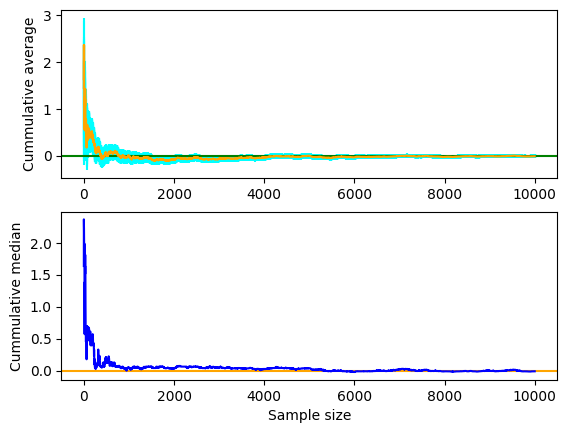

In [5]:
fig_norm_stats,ax_norm_stats = getStatisticsPlot(cummulative_Stats_Norm,norm_dist_dict,XVector)

### Pareto distribution

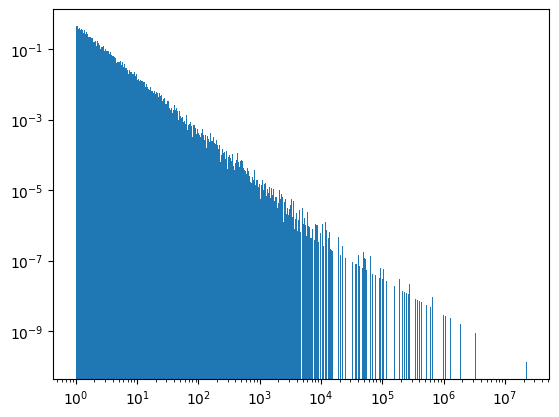

In [6]:
xM = 1
alpha = 0.5
Y_Pareto = 1+np.random.pareto(alpha,n)

fig_hist_pareto,ax_hist_pareto = getFixAxHeavyTailedHistogram(Y_Pareto)

cummulative_Stats_Pareto = getCummulativeStatistics(Y_Pareto)

#Based on the formulas from Wikipedia (https://en.wikipedia.org/wiki/Pareto_distribution):
pareto_mean = math.inf #For alpha<=1
pareto_median = xM*4 #0.5^sqrt(2) = 4
pareto_dist_dict = {"distMed":pareto_median,"distMean":pareto_mean}


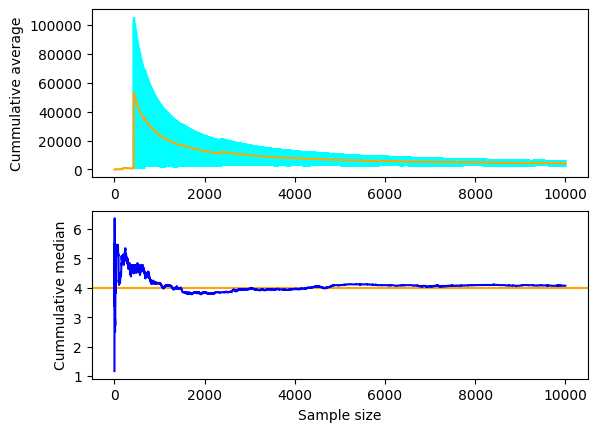

In [7]:
fig_pareto_stats,ax_pareto_stats = getStatisticsPlot(cummulative_Stats_Pareto,pareto_dist_dict,XVector)

### Log normal distribution

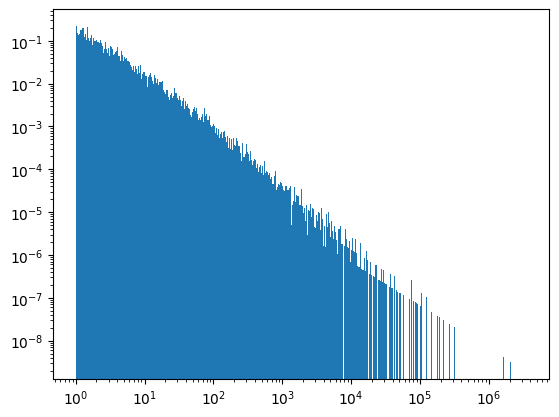

In [8]:
sigma = 4
Y_logNorm =  np.exp(sigma*np.random.standard_normal(n))
#Y_logNorm = np.random.lognormal(0,sigma,n)

fig_hist_logNorm,ax_hist_logNorm = getFixAxHeavyTailedHistogram(Y_logNorm)
#plt.hist(Y_logNorm,bins=100)

cummulative_Stats_LogNorm = getCummulativeStatistics(Y_logNorm)

#Based on the formulas from Wikipedia (https://en.wikipedia.org/wiki/Log-normal_distribution):
logNorm_mean = math.exp(16/2)
logNorm_median = math.exp(0)
logNorm_dist_dict = {"distMed":logNorm_median,"distMean":logNorm_mean}

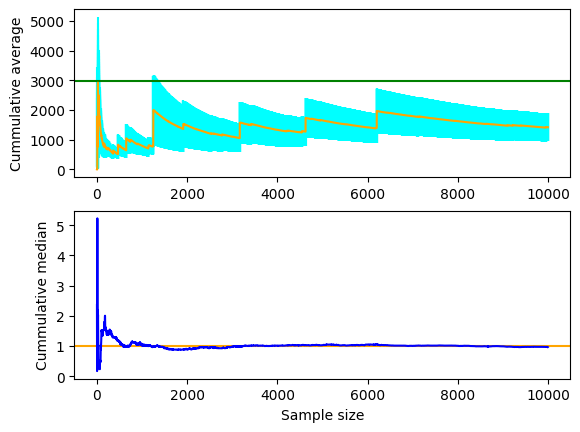

In [9]:
fig_logNorm_stats,ax_logNorm_stats = getStatisticsPlot(cummulative_Stats_LogNorm,logNorm_dist_dict,XVector)

### Paper sample

In [23]:
paper_DataFrame = pd.read_csv(r"C:\Users\DripTooHard\PycharmProjects\SocialInformatics\Assignment1\paper_dataset.csv",index_col=0)
citationCountArray = paper_DataFrame[paper_DataFrame["year"] == 2009]["citationCount"].tolist()

In [24]:
Y_Paper = citationCountArray

#We can only calculate the empirical statistics
dist_mean_paper = np.mean(Y_Paper)
dist_med_paper = np.median(Y_Paper)

paper_dist_dict = {"distMed":dist_med_paper,"distMean":dist_mean_paper}


(array([5.647e+03, 1.053e+03, 6.630e+02, ..., 0.000e+00, 0.000e+00,
        1.000e+00]),
 array([0.0000000e+00, 1.0147000e+01, 2.0294000e+01, ..., 2.0273706e+04,
        2.0283853e+04, 2.0294000e+04]),
 <BarContainer object of 2000 artists>)

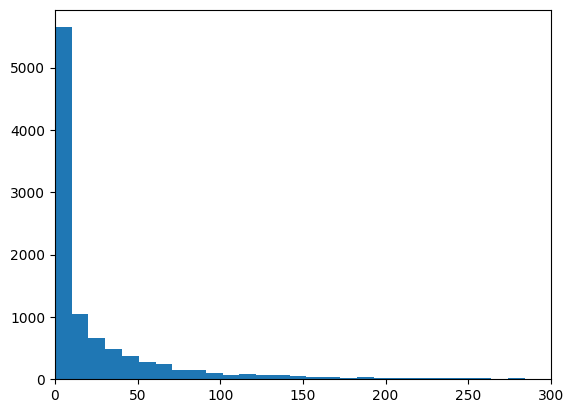

In [27]:
Y_PaperSamp = np.random.choice(citationCountArray,10000,replace=False)
#Y_PaperSamp = Y_Paper
XVector = createXVector(len(Y_PaperSamp))

cummulative_Stats_PaperSamp = getCummulativeStatistics(Y_PaperSamp)

#Once again, we can only calculate the empirical statistics
dist_mean_paper_samp = np.mean(Y_PaperSamp)
dist_med_paper_samp = np.median(Y_PaperSamp)

paperSamp_dist_dict = {"distMed":dist_med_paper_samp,"distMean":dist_mean_paper_samp}


#getFixAxHeavyTailedHistogram(Y_PaperSamp,400)
plt.xlim([0,300])
plt.hist(Y_PaperSamp,bins=2000)


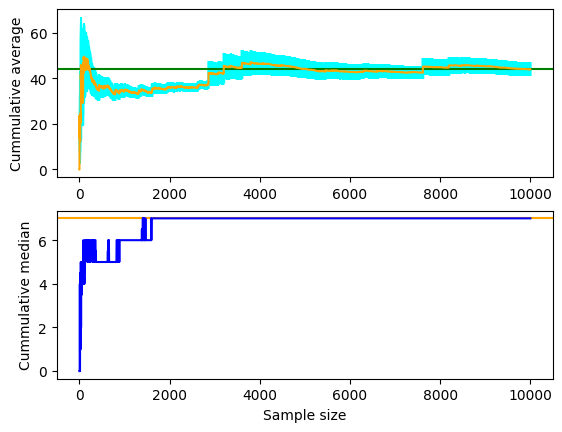

In [26]:
fig_paperSamp_stats,ax_paperSamp_stats = getStatisticsPlot(cummulative_Stats_PaperSamp,paperSamp_dist_dict,XVector)

### Part 3, excercise 1: Look at the cummulative means for the three distributions
###### Gaussian
For the normal distribution, the general trend for the empirical cumulative average is that it converges towards its theoretical mean. This makes sense, as the majority of the density of a Gaussian distribution is centrered around its mean.

###### Pareto
For the Pareto distribution, we see that there are a bunch of “spikes,” that keeps the cumulative mean from converging to a single value. This is due to single outlier datapoints greatly skewing the mean at those spike-points. As a Pareto distribution is a heavy tailed distribution, and therefore has a greater density at its outliers, it is not surprising that we see this kind of pattern.

Although, strictly speaking, it appears that the Pareto distribution IS converging towards its theoretical mean: Infinity. Albeit, it still does this much more noisily than the Gaussian distribution.

###### Lognormal
As can be no surprise, we observe the same pattern as with the Pareto for the lognormal distribution. This is of course because a lognormal distribution is a heavy tailed distribution itself.


### Part 3, excercise 2: Compare the cummulative median with the cummulative mean

#### Gaussian

For the Gaussian the mean and the median are the same, and the cummulatives converge to their respective theoretical statistics easily and without much divergence.

#### Pareto and log normal

For the two heavy tailed distributions, we see that the cummulative empirical means struggle with converging to the theoretical mean. This is due to the constant noise induced by the outliers, which produce these spikes before the cummulative means can converge to the theoretical means.

On the other hand, the median is much more robust towards outliers and therefore easily converges, even for the heavy tailed distributions, towards its theoretical counterpart.

In order to demonstrate, let us say we have 7 data points [0,1,2,3,4,5,6], the median being 3 and we get a 7th data point 2000000, the median goes from 3 to 3.5. While for the same scenario, the average would've gone from 3 to 250003.

It is therefore possible to conclude, that the median is much better at the describing the underlying distribution than the mean for heavy tailed distributions, as it is much more robust towards outliers.

#### Part 3, excercise 3: Consider the citation plot data

Looking at our graphs, we see that our histogram ressembles that of a power law, with the majority of samples concentrated around 0 and a tail that stretches all the way to around 200.

If we look at the line plots, we see that for the sample it has a hard time converging towards the mean. And even when it does the STD errors are relatively big compared to the normal distribution.

Of course, the plots are all dependent on the seed we use for generating the random samples. Sometimes we will also see a "traditional" heavy-tailed plot with spikes as in the other cases, although this doesn't occur as frequently and consistently as with the other cases. And sometimes - rarely - we even get plots that easily converge to the mean.

This might indicate, that our heavy-tailed distribution is a little less heavy-tailed than the other distributions. As we're sometimes able to sample our distribution without encountering any sudden spikes.

Furthermore, we see that the median is far from the average, that is, a few papers get a lot of citations while a lot of papers get very few citations. Which results in a skewed average.

In fact, if we look at the population as a whole, we can see that approximately 78% of the papers have fewer citations than the average, while the top fifteen thousand highest citations got ninety seven or more citations, with the highest hundred getting approx. 2500 or more and the highest getting over 20 thousand. The average being 40 citations.

In this particular case approximately 80% of the distribution lies under the average. The average is approx. 6 times greater than the median. Considering this means, that the 20% of the population above the average - the outliers - have been able to unproportionally skew the average, it appears that, we're following a power law distribution. That is, there is a skewed relationship between the citations and the average, where a very few number of outliers dominate the statistics of the distribution.

More concretly, it appears our data follows the 20-80 rule, where 80 percent of the citations are "owned" by 20% of our population.

We see a strongly similiar pattern of skewedness towards the extreme outliers for the random sample, lending itself to the same conclusion.


The implications of all of this is that we're dealing with a heavy-tailed distribution, following the power law.



In [14]:
papersBelowAverage = [paper for paper in Y_Paper if paper < dist_mean_paper]
print(f"Average for the whole population: {dist_mean_paper}\nRatio between the mean and the median: {dist_mean_paper/dist_med_paper}\nPercentage of papers below the average: {len(papersBelowAverage)/len(citationCountArray)*100}%")

Average for the whole population: 41.28319525584206
Ratio between the mean and the median: 5.897599322263152
Percentage of papers below the average: 78.68465451248993%


In [15]:
papersSampBelowAverage = [paperSamp for paperSamp in Y_PaperSamp if paperSamp < dist_mean_paper_samp]
print(f"Average for the sample: {dist_mean_paper_samp}\nRatio between the mean and the median: {dist_mean_paper/dist_med_paper_samp}\nPercentage of papers below the average: {len(papersSampBelowAverage)/len(Y_PaperSamp)*100}%")

Average for the sample: 41.4851
Ratio between the mean and the median: 5.897599322263152
Percentage of papers below the average: 78.55%


#### Part 3, excercise 4: Main message

It appears that the main message is twofold;

Descriptive statistics may not neccessarily accurately represent the underlying data. This was also the point of the linear regression excercises earlier in the course.

And the other being, that descriptive statistics are not created equal. And the choosing the right statistic is dependent on the underlying shape of the data.

Particularly in this case, samples taken from heavy tailed distributions are badly described by their means, but much better described by their medians.